n1 = 5, n2 = 9 th = 0.95

Merging Technique on hough lines
Determine lines on remaining CC of subset 1

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import math


from Processing import *
from ImageHandler import *
from GeometryProcessing import *
from ImageProcessing import *
from globalVar import *

In [2]:
rcParams['figure.figsize'] = 14, 28

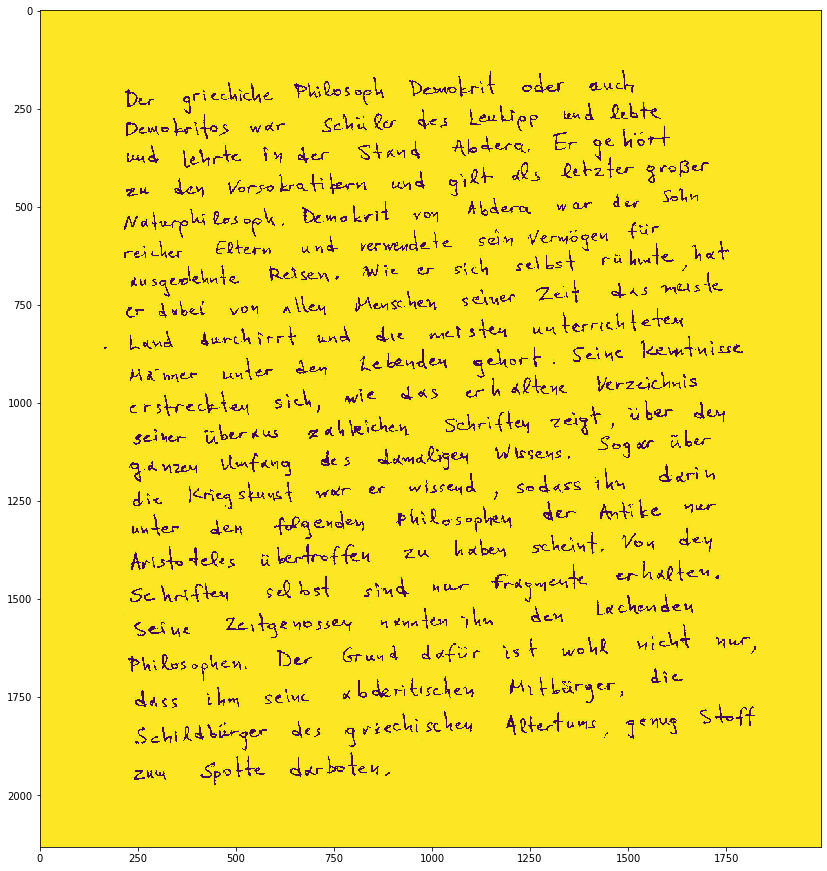

In [13]:
image = loadImage('../icdar/116.jpg')
plt.imshow(image);

In [14]:
# Find components and calc avg height of components, assume it equal to avg character width.
# Divide components into 3 subsets based on simple conditions

(labels, avg_height, centroids, stats) = findComponents(image)
((centroids1, stats1), (centroids2, stats2), (centroids3, stats3)) = divide(centroids, stats, avg_height);

'Found 1387 components with height 21.08507570295602 in image'

'Found 787 in subset 1, 5 in subset 2, and 595 in subset 3'

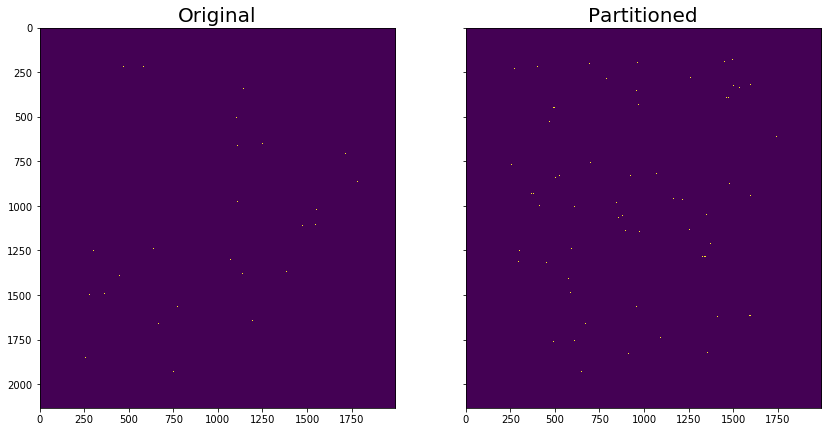

In [15]:
# Divide subset1 components into blocks of width aw and find their centroid. 

centroidP, mapP = partitionCC(stats1, int (avg_height));

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 28), sharex=True, sharey=True)

ax = axes.ravel()
ax[0].imshow(showCentroids(image, centroids1));
ax[0].set_title('Original', fontsize=20);

ax[1].imshow(showCentroids(image, centroidP));
ax[1].set_title('Partitioned', fontsize=20);

62 85


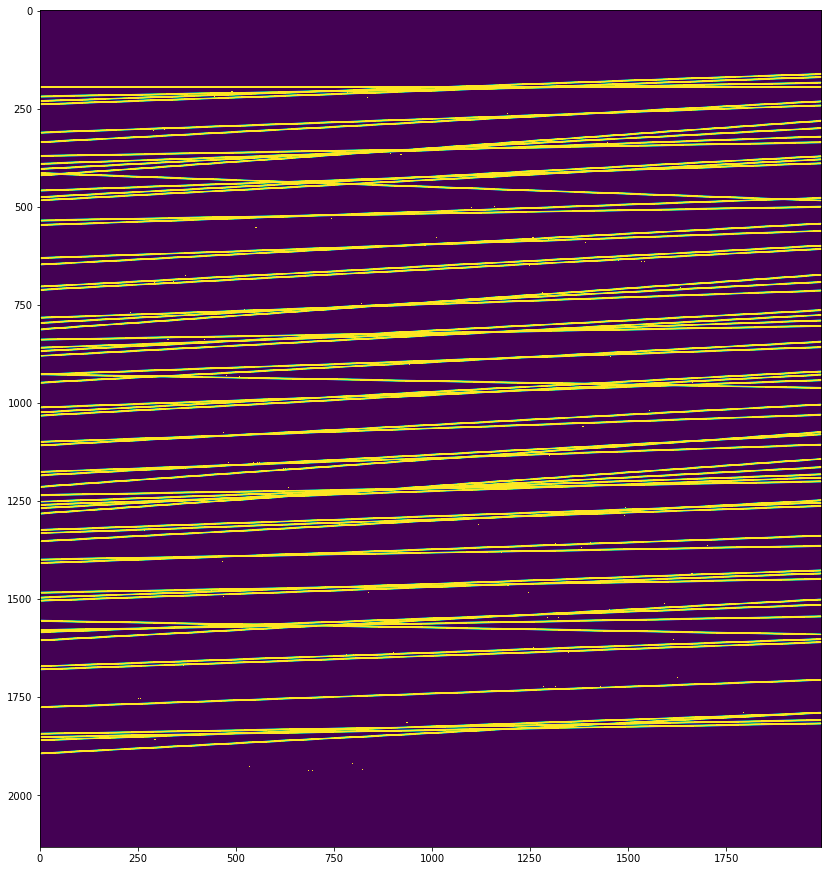

In [16]:
# Perform Hough transform on this with given parameters.
lines = [];
threshold = 10;
while (len(lines) < 4 or len(lines) > 70) and threshold < 500:
    lines = findHoughLines(showCentroids(image, centroidP), None, avg_height, threshold, 10, 40)
    threshold += 5;
if len(lines) < 4 and len(lines) > 100:
    print ('Empty')
    
print (len(lines), threshold);
init(lines, centroidP);

In [17]:
### Make a lookup array mapping partition to its cc
# Check dist of partition from primary line
# Find the CC of that partition from mapping
# If dist of that partition is within +-0.5p then increment value of that CC else decrement
# Discard all CC having +ve value and map to find partition being discarded
# repeat step unless max contri cell < n1
# if n2 > conti > n1, then cell must be within 2 degree from first found cell.

n = 1000;
selLines = [];
while (True):
    lineP, pos, n = findPrimaryCell(lines, centroidP);
    print ("\rContribution of " + str(n), end= " by this line ");
    if n < 5:
        break;
    elif n < 9:
        pTheta = math.radians(selLines[0][1]);
        theta = math.radians(lineP[1]);
        if (not (theta <= pTheta + 2 and theta >= pTheta - 2)):
            continue;
        print ("Low Contribution " + str(n), end = " ");
    
    centroidPN, count = discardPartition(lineP, np.copy(centroidP), centroids1, mapP)
    
    if (count == 0):
        break;
    
    print ("Discarded " + str(count) + " centroids");
    
    centroidP = np.copy(centroidPN);
    selLines.append(lineP);

print ("\n" + str(len(selLines)) + " lines selected");

Contribution of 24 by this line Discarded 46 centroids
Contribution of 20 by this line Discarded 30 centroids
Contribution of 2062 of 62 by this line Discarded 29 centroids
Contribution of 19 by this line Discarded 37 centroids
Contribution of 19 by this line Discarded 29 centroids
Contribution of 19 by this line Discarded 33 centroids
Contribution of 18 by this line Discarded 39 centroids
Contribution of 18 by this line Discarded 35 centroids
Contribution of 18 by this line Discarded 34 centroids
Contribution of 18 by this line Discarded 26 centroids
Contribution of 17 by this line Discarded 30 centroids
Contribution of 17 by this line Discarded 37 centroids
Contribution of 17 by this line Discarded 26 centroids
Contribution of 16 by this line Discarded 33 centroids
Contribution of 16 by this line Discarded 23 centroids
Contribution of 16 by this line Discarded 23 centroids
Contribution of 16 by this line Discarded 37 centroids
Contribution of 15 by this line Discarded 23 centroids
Co

In [18]:
count, nl = getIntersectionsH(selLines, image)
print (count);

29


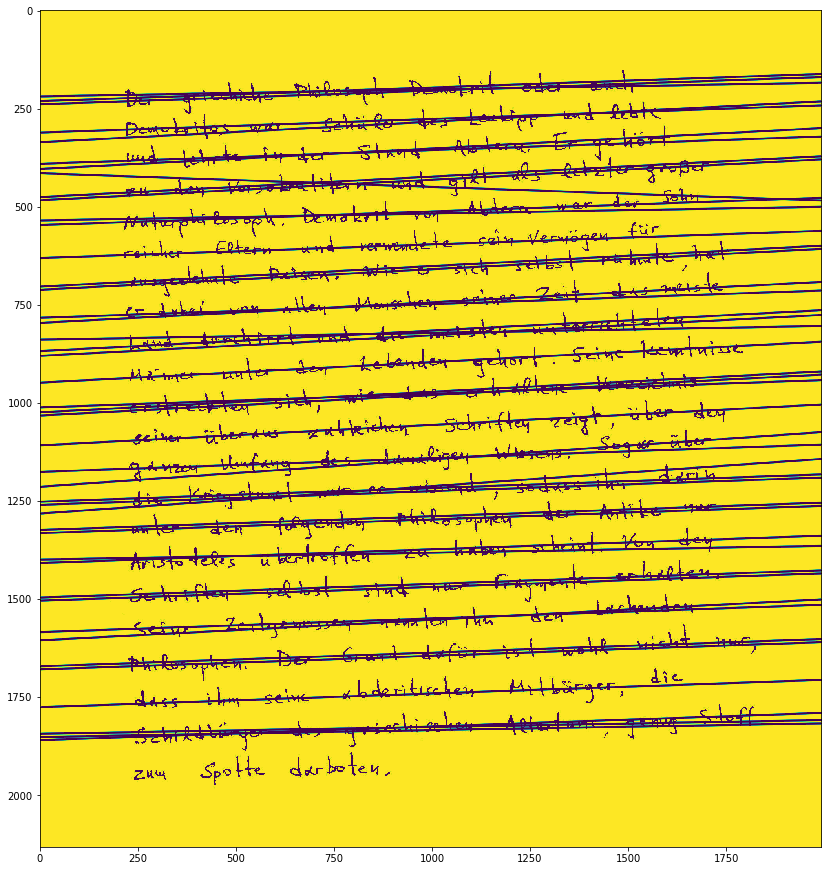

In [19]:
showLines(selLines, np.copy(image))

In [9]:
def isAdjacent(linei, linej):
    startLine = Line((0,0),(0,100));
    (_, yi) = linei.intersection(startLine)[0];
    (_, yj) = linej.intersection(startLine)[0];

    if abs(yi-yj) < 100:
        return True;
    else:
        return False;

def getIntersectionsH(lines, image):
    (h, w) = np.shape(image);
    Slines = []
    nlines = [];
    for line in lines:
        Slines.append(getLine(line));

    lineProcessed = [];
    distances = [];
    count = 0;
    for i in range(len(Slines)):
        if i in lineProcessed:
            continue;
        lineProcessed.append(i);
        count += 1;
        nlines.append(lines[i]);
        for j in range(len(Slines)):
            if j in lineProcessed:
                continue;

            linei = Slines[i];
            linej = Slines[j];
            if isAdjacent(linei, linej):
                inter = linei.intersection(linej);
                if inter != []:
                    inter = inter[0];
                else:
                    continue
                if inter.x < w and inter.x > 0:
                    lineProcessed.append(j);
                    distances.append( int(inter.distance(Point(w/2, inter.y))));

    return count, nlines;